In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datawarehouse import DataWarehouse
import matplotlib.cm as cm
import numpy as np

In [7]:
plt.style.use("seaborn-v0_8-whitegrid")
title_color = "#0d47a1"   
label_color = "#212121"  

In [8]:
dw = DataWarehouse(host="localhost", user="root", password="root", database="hires_model")
dw.connect()

Conexión exitosa a la base de datos


In [9]:
def run_query(query):
    cursor = dw.conn.cursor()
    cursor.execute(query)
    cols = [col[0] for col in cursor.description]
    data = cursor.fetchall()
    cursor.close()
    return pd.DataFrame(data, columns=cols)

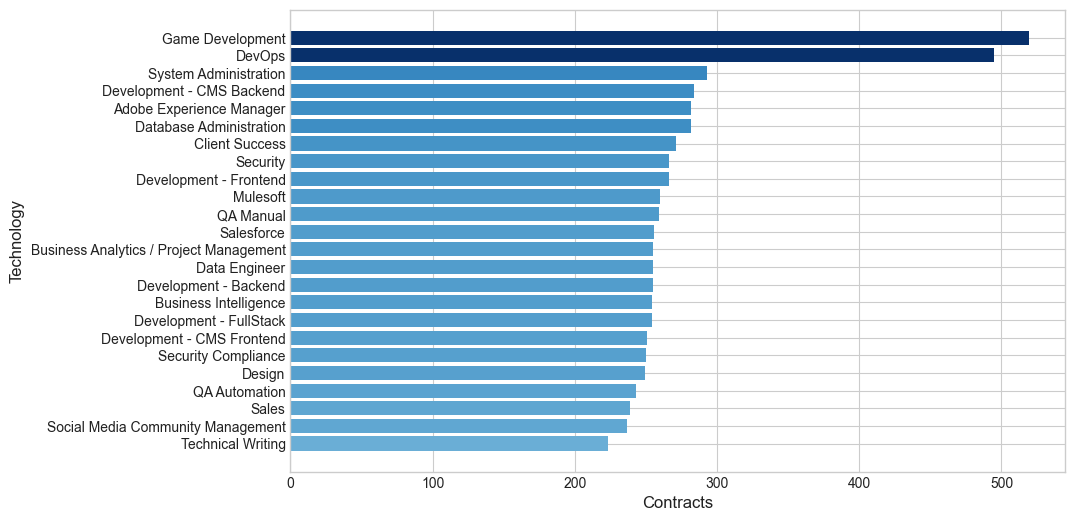

In [ ]:
query = """
SELECT t.technology_name, COUNT(f.hired) AS total_contrataciones
FROM fact_hires f
JOIN dim_technology t ON f.technology_id = t.technology_id
WHERE f.hired = 1
GROUP BY t.technology_name
ORDER BY total_contrataciones DESC;
"""
df_tec = run_query(query)

values = df_tec["total_contrataciones"]

norm = plt.Normalize(values.min(), values.max())
cmap = cm.Blues
colors = [cmap(0.5 + 0.7 * norm(v)) for v in values]

plt.figure(figsize=(10,6))
plt.barh(df_tec["technology_name"], values, color=colors)
plt.xlabel("Contracts", color=label_color, fontsize=12)
plt.ylabel("Technology", color=label_color, fontsize=12)
plt.gca().invert_yaxis()  
plt.xticks(color=label_color)
plt.yticks(color=label_color)
plt.show()

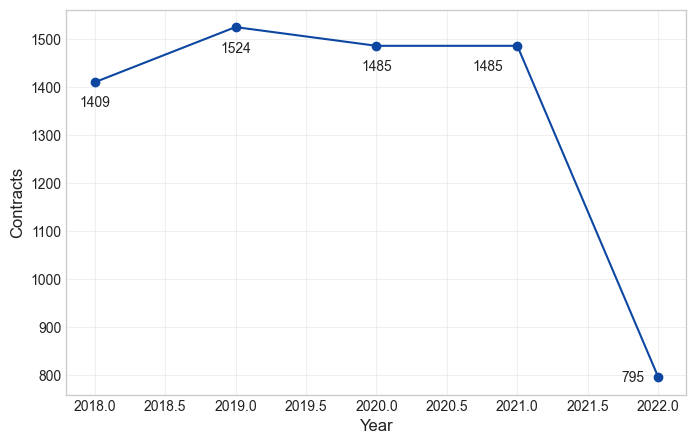

In [ ]:
query = """
SELECT d.year, COUNT(f.hired) AS total_contrataciones
FROM fact_hires f
JOIN dim_date d ON f.date_id = d.date_id
WHERE f.hired = 1
GROUP BY d.year
ORDER BY d.year;
"""
df_year = run_query(query)

plt.figure(figsize=(8,5))
plt.plot(df_year["year"], df_year["total_contrataciones"], marker="o", color=title_color)

for i, (x, y) in enumerate(zip(df_year["year"], df_year["total_contrataciones"])):
    if i == len(df_year) - 1:  
        plt.text(x - 0.1, y, str(y), ha="right", va="center", fontsize=10, color=label_color)
    elif i == len(df_year) - 2:  
        plt.text(x - 0.1, y - (y*0.02), str(y), ha="right", va="top", fontsize=10, color=label_color)
    else: 
        plt.text(x, y - (y*0.02), str(y), ha="center", va="top", fontsize=10, color=label_color)

plt.xlabel("Year", color=label_color, fontsize=12)
plt.ylabel("Contracts", color=label_color, fontsize=12)
#plt.title("Contracts by Year", color=title_color, fontsize=16, weight="bold")
plt.xticks(color=label_color)
plt.yticks(color=label_color)
plt.grid(True, alpha=0.3)
plt.show()

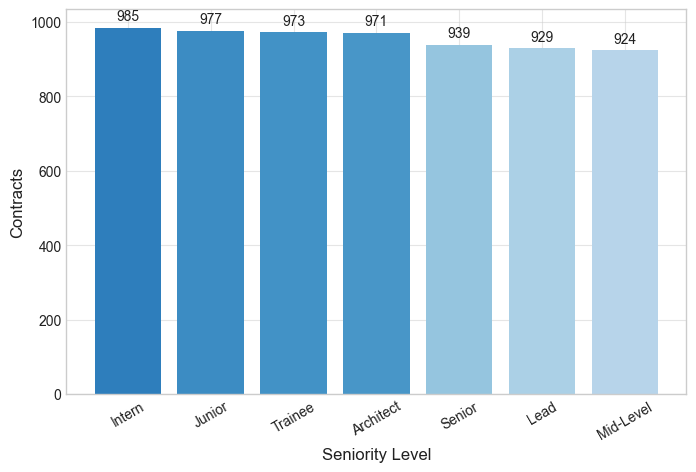

In [ ]:
query = """
SELECT s.senority_name, COUNT(f.hired) AS total_contrataciones
FROM fact_hires f
JOIN dim_seniority s ON f.senority_id = s.senority_id
WHERE f.hired = 1
GROUP BY s.senority_name
ORDER BY total_contrataciones DESC;
"""
df_seniority = run_query(query)

values = df_seniority["total_contrataciones"]


norm = plt.Normalize(values.min(), values.max())
cmap = cm.Blues
colors = [cmap(0.3 + 0.4 * norm(v)) for v in values]

plt.figure(figsize=(8,5))
plt.bar(df_seniority["senority_name"], values, color=colors)
plt.xlabel("Seniority Level", color=label_color, fontsize=12)
plt.ylabel("Contracts", color=label_color, fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5)
plt.bar_label(plt.gca().containers[0], fmt='%d', padding=3, color=label_color, fontsize=10)
#plt.title("Contracts by Seniority", color=title_color, fontsize=16, weight="bold")
plt.xticks(rotation=30, color=label_color)
plt.yticks(color=label_color)
plt.show()  

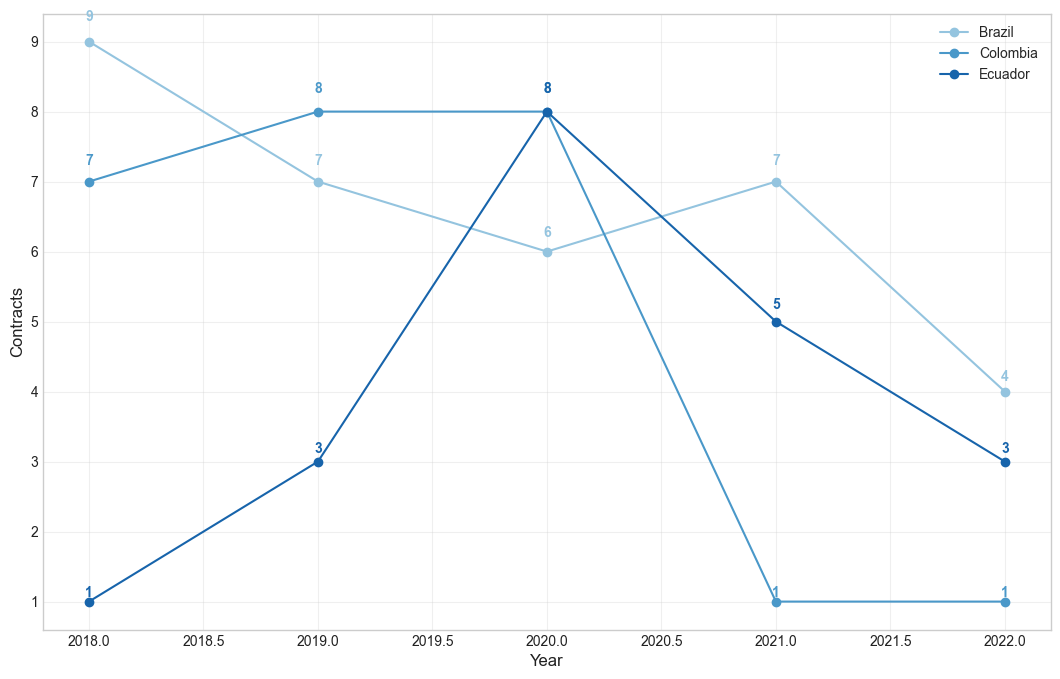

In [ ]:
query = """
SELECT d.year, c.country_name, COUNT(f.hired) AS total_contrataciones
FROM fact_hires f
JOIN dim_date d ON f.date_id = d.date_id
JOIN dim_country c ON f.country_id = c.country_id
WHERE f.hired = 1
  AND c.country_name IN ('United States', 'Brazil', 'Colombia', 'Ecuador')
GROUP BY d.year, c.country_name
ORDER BY d.year, c.country_name;
"""
df_country = run_query(query)

plt.figure(figsize=(13,8))

countries = df_country["country_name"].unique()
colors = [cm.Blues(i) for i in np.linspace(0.4, 0.8, len(countries))]

for country, color in zip(countries, colors):
    data = df_country[df_country["country_name"] == country]
    plt.plot(data["year"], data["total_contrataciones"], 
             marker="o", label=country, color=color)

    for x, y in zip(data["year"], data["total_contrataciones"]):
        plt.text(x, y + (y*0.028), str(y), ha="center", va="bottom", fontsize=10, color=color, weight="bold")

plt.xlabel("Year", color=label_color, fontsize=12)
plt.ylabel("Contracts", color=label_color, fontsize=12)
#plt.title("Contracts by Country over the Years", color=title_color, fontsize=16, weight="bold")
plt.legend()
plt.xticks(color=label_color)
plt.yticks(color=label_color)
plt.grid(True, alpha=0.3)
plt.show()


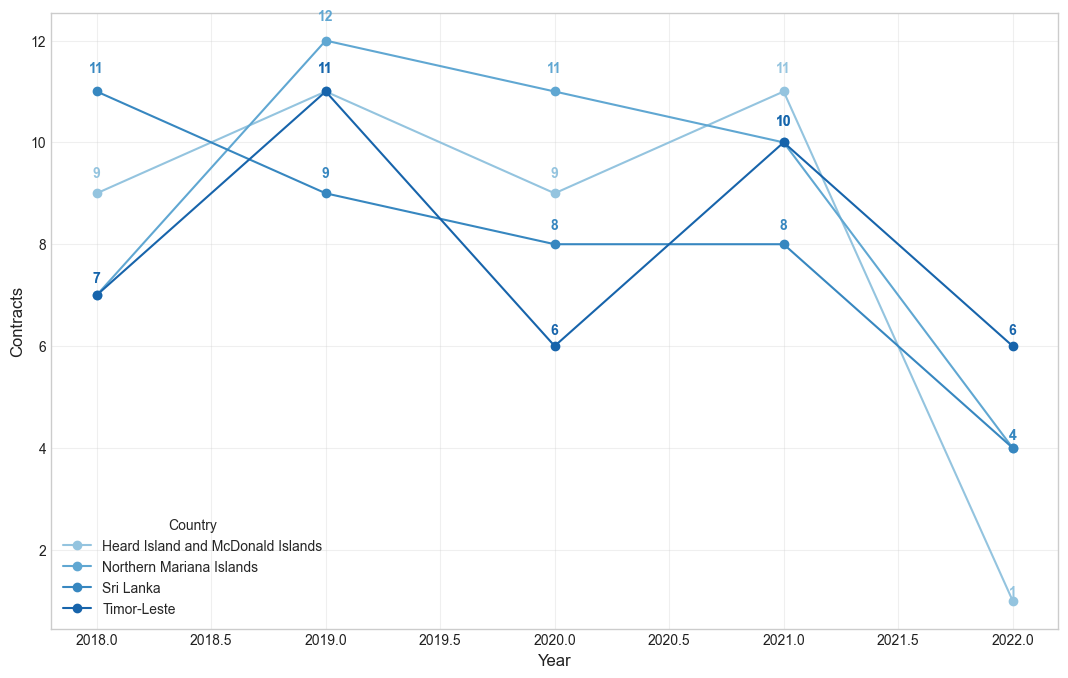

In [ ]:
query_top5 = """
SELECT c.country_name, COUNT(*) AS total_contrataciones
FROM fact_hires f
JOIN dim_country c ON f.country_id = c.country_id
WHERE f.hired = 1
GROUP BY c.country_name
ORDER BY total_contrataciones DESC
LIMIT 4;
"""
df_top5 = run_query(query_top5)
top5_countries = tuple(df_top5["country_name"].tolist())

query = f"""
SELECT d.year, c.country_name, COUNT(*) AS total_contrataciones
FROM fact_hires f
JOIN dim_date d ON f.date_id = d.date_id
JOIN dim_country c ON f.country_id = c.country_id
WHERE f.hired = 1
  AND c.country_name IN {top5_countries}
GROUP BY d.year, c.country_name
ORDER BY d.year, c.country_name;
"""
df_country = run_query(query)

plt.figure(figsize=(13,8))

countries = df_country["country_name"].unique()
colors = [cm.Blues(i) for i in np.linspace(0.4, 0.8, len(countries))]

for country, color in zip(countries, colors):
    data = df_country[df_country["country_name"] == country]
    plt.plot(data["year"], data["total_contrataciones"], 
             marker="o", label=country, color=color)

    # Etiquetas en cada punto
    for x, y in zip(data["year"], data["total_contrataciones"]):
        plt.text(x, y + (y*0.028), str(y), ha="center", va="bottom", 
                 fontsize=10, color=color, weight="bold")

plt.xlabel("Year", color=label_color, fontsize=12)
plt.ylabel("Contracts", color=label_color, fontsize=12)
plt.legend(title="Country")
plt.xticks(color=label_color)
plt.yticks(color=label_color)
plt.grid(True, alpha=0.3)
plt.show()

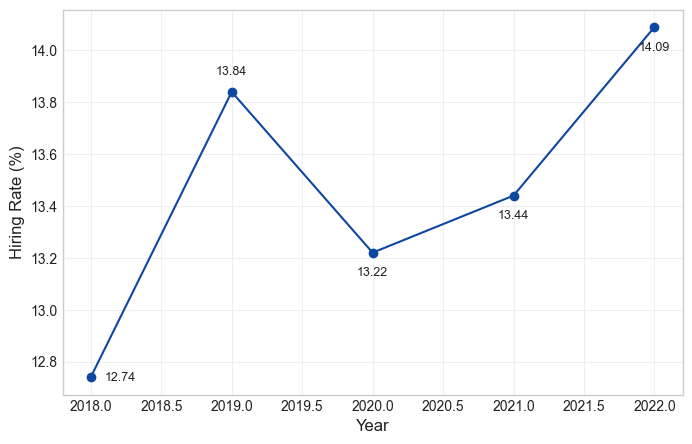

In [ ]:
query = """
SELECT d.year,
       ROUND(SUM(CASE WHEN f.hired = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS tasa_contratacion_pct
FROM fact_hires f
JOIN dim_date d ON f.date_id = d.date_id
GROUP BY d.year
ORDER BY d.year;
"""
df_tasa = run_query(query)

values = df_tasa["tasa_contratacion_pct"]
cmap = cm.Greens
line_color = title_color 

plt.figure(figsize=(8,5))
plt.plot(df_tasa["year"], values, marker="o", color=line_color)

for i, (x, y) in enumerate(zip(df_tasa["year"], values)):
    if i == 0: 
        plt.text(x + 0.1, float(y), str(y), ha="left", va="center", fontsize=9, color=label_color)
    elif i == 1: 
        plt.text(x, float(y) + (float(y) * 0.004), str(y), ha="center", va="bottom", fontsize=9, color=label_color)
    else:  
        plt.text(x, float(y) - (float(y) * 0.004), str(y), ha="center", va="top", fontsize=9, color=label_color)

plt.xlabel("Year", color=label_color, fontsize=12)
plt.ylabel("Hiring Rate (%)", color=label_color, fontsize=12)
#plt.title("Hiring Rate by Year", color=title_color, fontsize=16, weight="bold")
plt.xticks(color=label_color)
plt.yticks(color=label_color)
plt.grid(True, alpha=0.3)
plt.show()

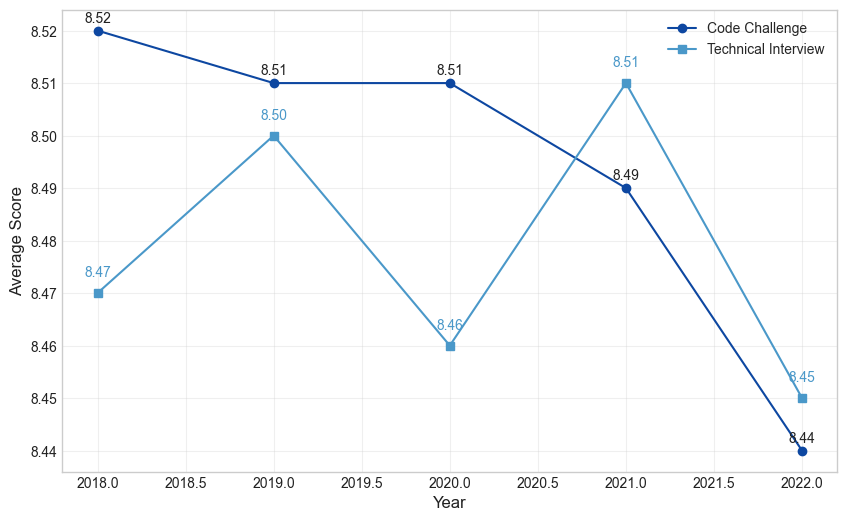

In [ ]:
query = """
SELECT d.year,
       ROUND(AVG(f.code_challenge_score), 2) AS promedio_code_challenge,
       ROUND(AVG(f.technical_interview_score), 2) AS promedio_technical_interview
FROM fact_hires f
JOIN dim_date d ON f.date_id = d.date_id
WHERE f.hired = 1
GROUP BY d.year
ORDER BY d.year;
"""
df_scores = run_query(query)

plt.figure(figsize=(10,6))
plt.plot(df_scores["year"], df_scores["promedio_code_challenge"], marker="o", label="Code Challenge", color=title_color)
plt.plot(df_scores["year"], df_scores["promedio_technical_interview"], marker="s", label="Technical Interview", color=colors[1])

for x, y in zip(df_scores["year"], df_scores["promedio_code_challenge"]):
    plt.text(x, float(y) + 0.001, str(y), ha="center", va="bottom", fontsize=10, color=label_color)
for x, y in zip(df_scores["year"], df_scores["promedio_technical_interview"]):
    plt.text(x, float(y) + 0.0025, str(y), ha="center", va="bottom", fontsize=10, color=colors[1])

plt.xlabel("Year", color=label_color, fontsize=12)
plt.ylabel("Average Score", color=label_color, fontsize=12)
#plt.title("Average Scores by Year", color=title_color, fontsize=16, weight="bold")
plt.legend()
plt.xticks(color=label_color)
plt.yticks(color=label_color)
plt.grid(True, alpha=0.3)
plt.show()
